In [1]:
import sys
sys.path.append("../../smsl")

In [2]:
from smsl.makeDataframe import SpringAgent
from smsl.config import ConfAgent
from smsl.graph import ST_g4dna
from smsl.plotAgent import PlotAgent, palette
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

In [3]:
import os
import pandas as pd
import numpy as np
from IPython.display import JSON
import json
import matplotlib.pyplot as plt

In [4]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        # ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            # os.chdir(f'../../{system}/d.fluctmatch')
            # b_agent = BigTrajGraphAgent(self.MAgent)
            b_agent = SpringAgent()
            b_agent.system_offical_name = system_offical_name
            self[system] = b_agent
        # os.chdir(ori_path)
    def read_dict_hotspot_from_json(self, subgroups, is_return=False):
        dict_hotspot = {}
        for s in subgroups:
            with open(f'./data/{s}.json', 'r') as f:
                data = json.load(f)
                dict_hotspot[s] = {system:d1 for system, d1 in data.items() if system in self.keys()} 
            for system, d1 in dict_hotspot[s].items():
                positions = list(d1.keys())
                for position in positions:
                    position_tuple = tuple(position.split(','))
                    if len(position_tuple)==1:
                        position_tuple = position_tuple[0]
                    d1[position_tuple] = d1.pop(position)
        if is_return:
            return dict_hotspot
        else:
            self.dict_hotspot = dict_hotspot
    def get_df_k_with_hotspots(self, k_value='k_avg_std', sele_windows=list(range(1, 19+1)), sele_systems=None, is_return=False): ## for s = st
        list_k_with_hotspots = []
        for s, dict_subgroup in self.dict_hotspot.items(): 
            for system, dict_system in dict_subgroup.items():
                if (not sele_systems is None) and (not system in sele_systems): continue
                for position, dict_position in dict_system.items():
                    pos_col, pos_row = position[0], position[1]
                    time_label2k = dict_position['hotspot']['avg']
                    time_label2k = {time_label:k for window, (time_label, k) in enumerate(time_label2k.items(), start=1) if window in sele_windows}
                    k_avg = pd.Series(time_label2k).mean()
                    k_std = pd.Series(time_label2k).std()
                    list_k_with_hotspots.append({
                        'system'   : self[system].system_offical_name,
                        'layer'    : pos_row,
                        'gstrand'  : pos_col,
                        'k_avg'    : k_avg,
                        'k_std'    : k_std,
                        'k_avg_std': f'{k_avg:.2f} ± {k_std:.2f}',
                    })
        df_k_with_hotspots_1 = pd.DataFrame(list_k_with_hotspots)
        df_k_with_hotspots = df_k_with_hotspots_1.set_index(['system', 'layer'])
        df_k_with_hotspots = df_k_with_hotspots.pivot(columns='gstrand', values=k_value)

        ## sort the row and column index
        sort_system  = list(dict.fromkeys(df_k_with_hotspots_1['system']))
        sort_layer   = list(dict.fromkeys(df_k_with_hotspots_1['layer']))
        sort_gstrand = list(dict.fromkeys(df_k_with_hotspots_1['gstrand']))
        sort_row = [[system, layer] for system in sort_system for layer in sort_layer]
        df_k_with_hotspots = df_k_with_hotspots.loc[sort_row, sort_gstrand]
        if is_return:
            return df_k_with_hotspots
        else:
            self.df_k_with_hotspots = df_k_with_hotspots 

In [86]:
def add_df_k_with_hotspots_to_dict(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std, sele_systems, pose2sele_windows, verbose=1):
    for pose, sele_windows in pose2sele_windows.items():
        key_name = system2offical_name[sele_systems[0]] if pose=='all' else system2offical_name[sele_systems[0]]+'-'+pose
        ## add 'k_avg' to system_pose2df_k_with_hotspots_avg
        df_k_with_hotspots_avg = hs_agent.get_df_k_with_hotspots(k_value='k_avg', sele_windows=sele_windows, sele_systems=sele_systems, is_return=True)
        system_pose2df_k_with_hotspots_avg[key_name] = df_k_with_hotspots_avg
        ## add 'k_std' to system_pose2df_k_with_hotspots_std
        df_k_with_hotspots_std = hs_agent.get_df_k_with_hotspots(k_value='k_std', sele_windows=sele_windows, sele_systems=sele_systems, is_return=True)
        system_pose2df_k_with_hotspots_std[key_name] = df_k_with_hotspots_std
        if verbose==0: return
        ## print avg ± std
        df_k_with_hotspots = hs_agent.get_df_k_with_hotspots(sele_windows=sele_windows, sele_systems=sele_systems, is_return=True)
        print('pose', pose)
        display(df_k_with_hotspots)

In [140]:
def plot_k_st(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std):
    p_agent = PlotAgent(nrows=2, ncols=1, figsize_1=[5.0, 2.0], dpi=150, sharey=True)
    for (system_pose, df_k_with_hotspots_avg), (system_pose, df_k_with_hotspots_std) in zip(system_pose2df_k_with_hotspots_avg.items(), system_pose2df_k_with_hotspots_std.items()):
        for i_layer, layer in enumerate(['top', 'bot']):
            df_layer_avg = df_k_with_hotspots_avg.xs(layer, level='layer')
            df_layer_std = df_k_with_hotspots_std.xs(layer, level='layer')
            gstrands = df_layer_avg.columns
            ks_avg = df_layer_avg.to_numpy().flatten()
            ks_std = df_layer_std.to_numpy().flatten()
            # line, = p_agent.axs[i_layer].plot(gstrands, ks_avg, label=system_pose, marker='o', markersize=4, color=None)
            if system_pose is min(system_pose2df_k_with_hotspots_avg, key=len): ## apo system
                color = 'black'
            else:
                color = None
            p_agent.axs[i_layer].errorbar(gstrands, ks_avg, yerr=ks_std, fmt='o-', markersize=4, capsize=3, label=system_pose, color=color)
            p_agent.axs[i_layer].set_ylabel(layer)

    p_agent.fig.text(0.60, 0.92, r'$k^{\rm{st}}$ in kcal mol$^{-1}$ $\rm{\AA}^{-2}$')
    p_agent.set_legend(
        ncols=1, 
        bbox_to_anchor=(-0.01, 1.0), 
        linewidth=1.2, 
        loc='lower left'
    )
    return p_agent

In [141]:
system2offical_name = {
'propeller': 'Propeller',
# 'basket'   : 'Basket',
# 'chair'    : 'Chair',
# 'hybrid-i' : 'Hybrid-I',
# 'hybrid-ii': 'Hybrid-II',
# 'dsdna'    : 'dsDNA',
# 'basket_na': 'Basket-Na',
'hybrid-ii_wttel26'    : 'Hybrid-II-wtTel26',
'propeller_poh'        : 'Propeller-POH',
'propeller_ewv'        : 'Propeller-EWV', 
'hybrid-ii_wttel26_ewv': 'Hybrid-II-wtTel26-EWV', 
'hybrid-ii_wttel26_poh': 'Hybrid-II-wtTel26-POH', 
}

subgroups = ['st']

In [142]:
hs_agent = HotSpotAgent(ST_g4dna)
hs_agent.load_systems(system2offical_name)
hs_agent.read_dict_hotspot_from_json(subgroups)
hs_agent.get_df_k_with_hotspots()

In [143]:
JSON(hs_agent.dict_hotspot)

<IPython.core.display.JSON object>

/home/user/anaconda3/envs/fluctmatch/lib/python3.8/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
keys must be str, int, float, bool or None, not tuple
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


### Propeller Apo v.s. POH v.s. EWV $k^{\text{st}}$

In [144]:
system_pose2df_k_with_hotspots_avg = {}
system_pose2df_k_with_hotspots_std = {}

In [145]:
sele_systems = ['propeller_poh']
pose2sele_windows = {
'a': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
'b': [14, 15, 19],
'c': [17],
} 
    
add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose a


gstrand                       Q3           Q2           Q1           Q4
system        layer                                                    
Propeller-POH top    3.98 ± 0.43  4.51 ± 0.23  5.08 ± 0.18  4.32 ± 0.28
              bot    4.24 ± 0.15  3.80 ± 0.32  4.27 ± 0.29  4.03 ± 0.29

pose b


gstrand                       Q3           Q2           Q1           Q4
system        layer                                                    
Propeller-POH top    3.98 ± 0.26  4.91 ± 0.05  5.08 ± 0.15  4.66 ± 0.22
              bot    4.55 ± 0.11  4.94 ± 0.12  4.30 ± 0.10  4.30 ± 0.27

pose c


gstrand                      Q3          Q2          Q1          Q4
system        layer                                                
Propeller-POH top    4.48 ± nan  5.17 ± nan  4.80 ± nan  4.46 ± nan
              bot    4.65 ± nan  4.44 ± nan  4.63 ± nan  4.54 ± nan

In [146]:
sele_systems = ['propeller']
pose2sele_windows = {
'all': list(range(1, 19+1)), ## [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
}


add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose all


gstrand                   Q3           Q2           Q1           Q4
system    layer                                                    
Propeller top    4.37 ± 0.28  3.97 ± 0.39  3.93 ± 0.33  4.17 ± 0.25
          bot    4.32 ± 0.32  4.22 ± 0.29  3.90 ± 0.58  3.78 ± 0.51

(3.2, 5.3)

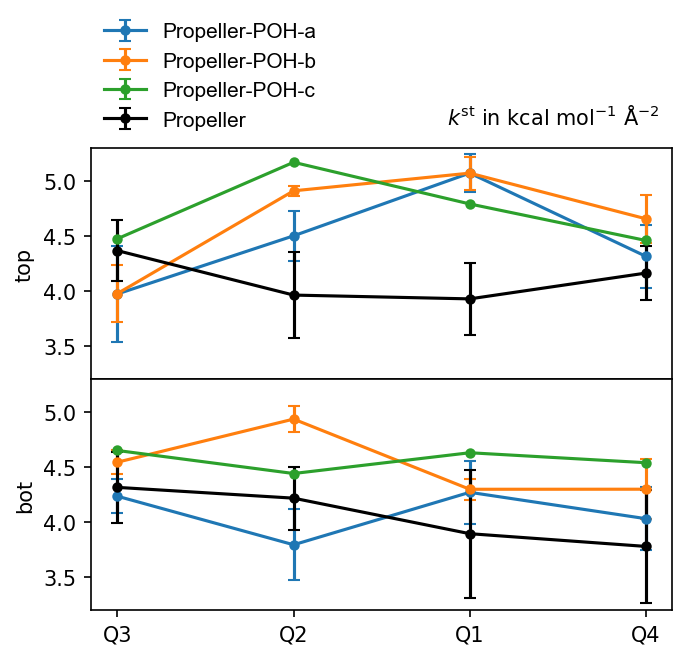

In [153]:
p_agent = plot_k_st(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std)
p_agent.axs[0].set_ylim(3.20, 5.30)
p_agent.fig.savefig('pic/kst_propeller_apo_vs_poh.svg', transparent=True, bbox_inches='tight')

In [158]:
system_pose2df_k_with_hotspots_avg = {}
system_pose2df_k_with_hotspots_std = {}

In [159]:
sele_systems = ['propeller_ewv']
pose2sele_windows = {
'all': list(range(1, 19+1)), ## [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
}


add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose all


gstrand                       Q3           Q2           Q1           Q4
system        layer                                                    
Propeller-EWV top    3.97 ± 0.45  4.63 ± 0.60  4.56 ± 0.43  4.18 ± 0.17
              bot    4.07 ± 0.36  4.80 ± 0.33  4.37 ± 0.70  4.26 ± 0.31

In [160]:
sele_systems = ['propeller']
pose2sele_windows = {
'all': list(range(1, 19+1)), ## [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
}


add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose all


gstrand                   Q3           Q2           Q1           Q4
system    layer                                                    
Propeller top    4.37 ± 0.28  3.97 ± 0.39  3.93 ± 0.33  4.17 ± 0.25
          bot    4.32 ± 0.32  4.22 ± 0.29  3.90 ± 0.58  3.78 ± 0.51

(3.2, 5.3)

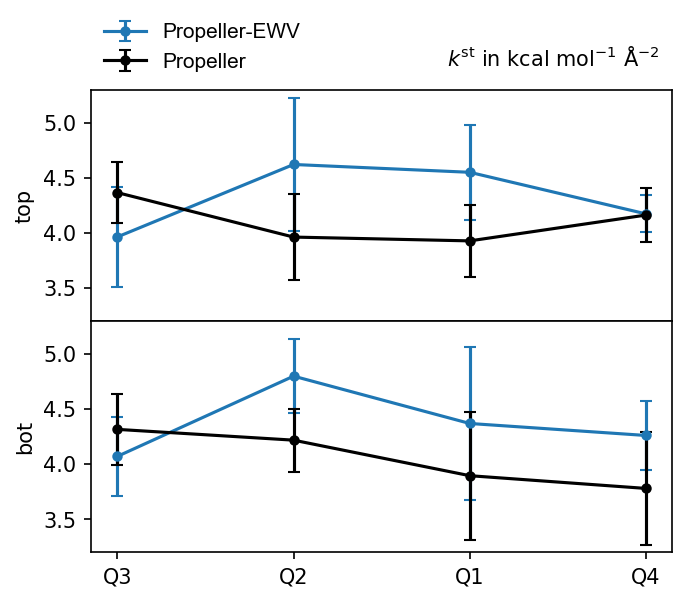

In [162]:
p_agent = plot_k_st(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std)
p_agent.axs[0].set_ylim(3.20, 5.30)
p_agent.fig.savefig('pic/kst_propeller_apo_vs_ewv.svg', transparent=True, bbox_inches='tight')

### Hybrid-II Apo v.s. EWV v.s. POH $k^{\text{st}}$

In [167]:
system_pose2df_k_with_hotspots_avg = {}
system_pose2df_k_with_hotspots_std = {}

In [168]:
sele_systems = ['hybrid-ii_wttel26_ewv']
pose2sele_windows = {
'a': [1, 2, 3, 4, 5, 6, 7, 8],
'b': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
}

add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose a


gstrand                               Q3           Q2           Q1  \
system                layer                                          
Hybrid-II-wtTel26-EWV top    5.78 ± 0.21  5.59 ± 0.87  6.07 ± 0.28   
                      bot    2.19 ± 0.21  1.56 ± 0.12  2.18 ± 0.29   

gstrand                               Q4  
system                layer               
Hybrid-II-wtTel26-EWV top    4.38 ± 0.40  
                      bot    2.33 ± 0.47

pose b


gstrand                               Q3           Q2           Q1  \
system                layer                                          
Hybrid-II-wtTel26-EWV top    5.91 ± 0.22  6.38 ± 0.10  6.29 ± 0.17   
                      bot    2.30 ± 0.12  1.68 ± 0.04  2.15 ± 0.12   

gstrand                               Q4  
system                layer               
Hybrid-II-wtTel26-EWV top    4.39 ± 0.13  
                      bot    2.14 ± 0.10

In [169]:
sele_systems = ['hybrid-ii_wttel26']
pose2sele_windows = {
'all': list(range(1, 19+1)) ## [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
}

add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose all


gstrand                           Q3           Q2           Q1           Q4
system            layer                                                    
Hybrid-II-wtTel26 top    6.56 ± 0.29  2.98 ± 0.13  7.63 ± 0.32  5.69 ± 0.17
                  bot    5.61 ± 0.20  3.24 ± 0.14  6.40 ± 0.25  4.10 ± 0.14

(1.23, 8.1)

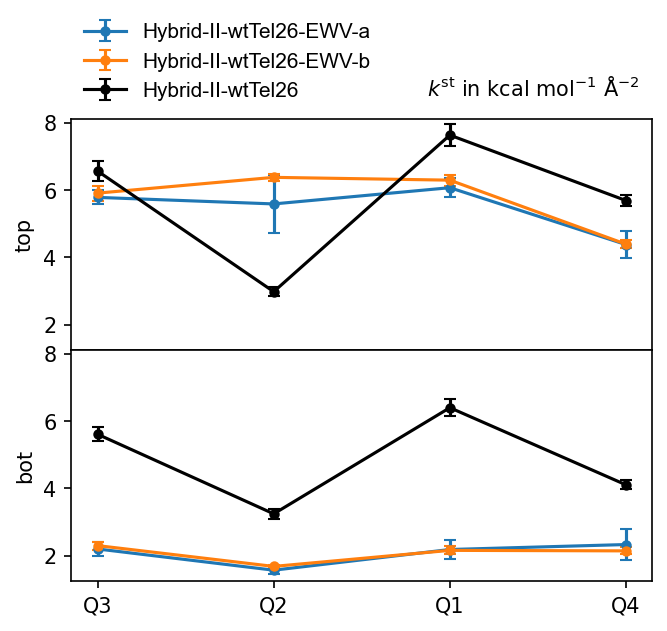

In [172]:
p_agent = plot_k_st(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std)
p_agent.axs[0].set_ylim(1.23, 8.10)
p_agent.fig.savefig('pic/kst_hybrid-ii_apo_vs_ewv.svg', transparent=True, bbox_inches='tight')

In [174]:
system_pose2df_k_with_hotspots_avg = {}
system_pose2df_k_with_hotspots_std = {}

In [175]:
sele_systems = ['hybrid-ii_wttel26_poh']
pose2sele_windows = {
'a': [1, 2, 3, 4, 5, 6, 7, 8],
'b': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
}

add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose a


gstrand                               Q3           Q2           Q1  \
system                layer                                          
Hybrid-II-wtTel26-POH top    6.65 ± 0.20  4.14 ± 0.24  6.10 ± 0.22   
                      bot    3.38 ± 0.42  2.07 ± 0.46  2.45 ± 0.23   

gstrand                               Q4  
system                layer               
Hybrid-II-wtTel26-POH top    5.38 ± 0.30  
                      bot    2.71 ± 0.51

pose b


gstrand                               Q3           Q2           Q1  \
system                layer                                          
Hybrid-II-wtTel26-POH top    6.47 ± 0.39  7.01 ± 0.30  5.58 ± 0.51   
                      bot    2.32 ± 0.11  1.54 ± 0.13  2.12 ± 0.12   

gstrand                               Q4  
system                layer               
Hybrid-II-wtTel26-POH top    4.69 ± 0.20  
                      bot    1.78 ± 0.16

In [176]:
sele_systems = ['hybrid-ii_wttel26']
pose2sele_windows = {
'all': list(range(1, 19+1)) ## [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
}

add_df_k_with_hotspots_to_dict(
    system_pose2df_k_with_hotspots_avg, 
    system_pose2df_k_with_hotspots_std, 
    sele_systems,
    pose2sele_windows,
    verbose=1,    
)

pose all


gstrand                           Q3           Q2           Q1           Q4
system            layer                                                    
Hybrid-II-wtTel26 top    6.56 ± 0.29  2.98 ± 0.13  7.63 ± 0.32  5.69 ± 0.17
                  bot    5.61 ± 0.20  3.24 ± 0.14  6.40 ± 0.25  4.10 ± 0.14

(1.23, 8.1)

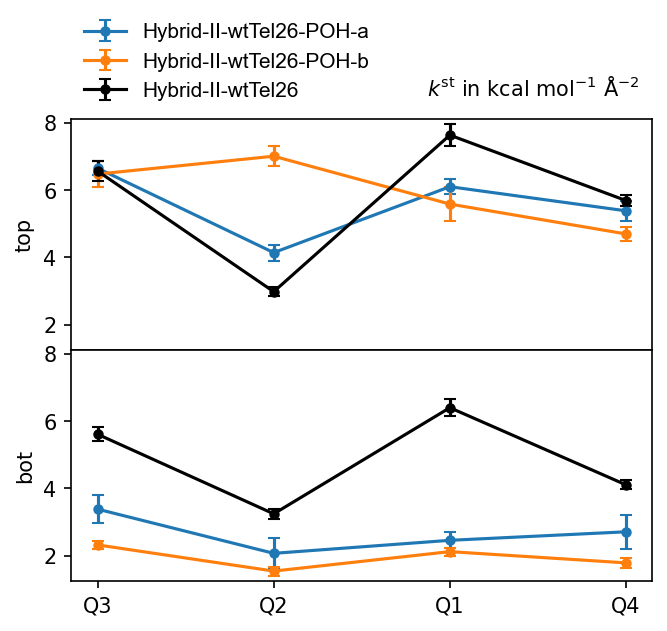

In [179]:
p_agent = plot_k_st(system_pose2df_k_with_hotspots_avg, system_pose2df_k_with_hotspots_std)
p_agent.axs[0].set_ylim(1.23, 8.10)
p_agent.fig.savefig('pic/kst_hybrid-ii_apo_vs_poh.svg', transparent=True, bbox_inches='tight')